<a href="https://colab.research.google.com/github/gimesia/misa/blob/main/lab4/MISA_UNET3_SynthSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tutorial # 3 - Contrast agnostic training**

Idea:

1.   Determine tissue intensities
2.   Determine blurring parameters
3.   Determine noise parameters
4.   Train a simple contrast-agnostic model

**Import libraries**

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

**Mount drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


**Define parameters**

In [ ]:
import os

os.listdir("/content/drive/MyDrive/Colab Notebooks")

['OASIS_subset_sorted',
 'unet_images',
 'MISA_UNET_Tutorial-1_Introduction.ipynb',
 'MISA_Lab3_Tutorial-3_SynthSeg.ipynb']

In [ ]:
# dataset parameters
FNAME_PATTERN = '/content/drive/MyDrive/Colab Notebooks/OASIS_subset_sorted/OAS2_{0:04d}_MR1/OAS2_{0:04d}_MR1{1:}.nii.gz'
pattern = lambda x,y: f"/content/drive/MyDrive/Colab Notebooks/OASIS_subset_sorted/OAS2_{x:04d}_MR1/OAS2_{x:04d}_MR1{y:}.nii.gz"
IMAGE_SIZE = (128, 256, 256)

# network parameters
N_CLASSES = 4
N_INPUT_CHANNELS = 1
SCALING_FACTOR = 1
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (16, 16)

# training, validation, test parameters
TRAINING_VOLUMES = [2, 7, 9, 10, 12, 13, 14, 16, 18]
VALIDATION_VOLUMES = [20, 21, 22, 26]
TEST_VOLUMES = [29] # Difficult volumes: 4, 5, 8, 12, 17, 23, 28

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 20
BATCH_SIZE = 32
PATIENCE = 5
MODEL_FOLDER = 'checkpoint.keras'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'

**Define UNet architecture**

In [ ]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scaling_factor=SCALING_FACTOR):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(inputs)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(max1)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(max2)
    max3 = layers.MaxPooling2D((2, 2))(conv3)

    lat = layers.Conv2D(256*scaling_factor, (3, 3), padding="same", activation='relu')(max3)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    cat1 = layers.Concatenate()([up1, conv3])
    conv4 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(cat1)

    up2 = layers.UpSampling2D((2, 2))(conv4)
    cat2 = layers.Concatenate()([up2, conv2])
    conv5 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(cat2)

    up3 = layers.UpSampling2D((2, 2))(conv5)
    cat3 = layers.Concatenate()([up3, conv1])
    conv6 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(cat3)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

**Load data**

In [ ]:
def load_data(volume_list, image_size=IMAGE_SIZE, fname_pattern=pattern) :
  n_volumes = len(volume_list)
  T1_volumes = np.zeros((n_volumes, *image_size, 1))
  labels = np.zeros((n_volumes, *image_size, 1))
  for iFile, iID in enumerate(volume_list) :
    img_data = nib.load(fname_pattern(iID, '_BrainExtractionBrain'))
    T1_volumes[iFile, ..., 0] = np.transpose(img_data.get_fdata(), (2, 0, 1))

    seg_data = nib.load(fname_pattern(iID, '_Segmentation'))
    labels[iFile, ..., 0] = np.transpose(seg_data.get_fdata(), (2, 0, 1))

  return (T1_volumes, labels)

In [ ]:
(training_volumes_T1, training_labels) = load_data(TRAINING_VOLUMES)
(validation_volumes_T1, validation_labels) = load_data(VALIDATION_VOLUMES)
(testing_volumes_T1, testing_labels) = load_data(TEST_VOLUMES)

In [ ]:
def zscore(x) :
  return (x-x[x>0].mean())/x[x>0].std()

def zscore_array(array) :
  return np.array([zscore(x) for x in array])

training_volumes_T1 = zscore_array(training_volumes_T1)
validation_volumes_T1 = zscore_array(validation_volumes_T1)
testing_volumes_T1 = zscore_array(testing_volumes_T1)

**Extract *useful* patches**

This step is fundamental, we want to provide the network with useful information

In [ ]:
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [ ]:
def extract_useful_patches(
    volumes, labels,
    use_one_hot_encoding=False,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])

  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])

  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  seg_patches = seg_patches[useful_patches]

  if use_one_hot_encoding :
    seg_patches = tf.keras.utils.to_categorical(
      seg_patches, num_classes=N_CLASSES)

  return (vol_patches, seg_patches)

In [ ]:
# extract patches from training set
(_, training_patches_seg) = extract_useful_patches(training_volumes_T1, training_labels, use_one_hot_encoding=False)

# extract patches from validation set
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(validation_volumes_T1, validation_labels, use_one_hot_encoding=True)

In [ ]:
import numpy as np
import random
from scipy.ndimage import gaussian_filter
import cv2

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, labels, shuffle=True):
        'Initialization'
        self.dim = PATCH_SIZE
        self.batch_size = BATCH_SIZE
        self.list_IDs = range(labels.shape[0])
        self.labels = labels
        self.n_channels = N_INPUT_CHANNELS
        self.n_classes = N_CLASSES
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=float)
        Y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            map = self.labels[ID]

            # Step 1 - create an image of the size of map
            sample = np.zeros_like(map)

            # Step 2 - pick intensities at random from the intensity distribution of each class

            prev_lowest = 1
            for c in range(1,4):
              rand_intensity = np.random.randint(0, 100)
              sample[np.where(map == c)] = rand_intensity
              prev_lowest = rand_intensity

            # Step 3 - blur the image
            sigma = np.random.uniform(0.95, 1)
            sample = cv2.blur(sample, (3,3))

            # Step 4 - add additive white Gaussian noise

            noise_amp = np.random.uniform(0, 0.2)
            noise_im = np.random.normal(scale=noise_amp, size=sample.shape)
            sample = sample + noise_im

            sample = zscore(sample)

            ## transform map into an image
            X[i, ] = sample.reshape((*self.dim, self.n_channels))

            # Store class
            Y[i, ] =  tf.keras.utils.to_categorical(map, num_classes=self.n_classes)

        return X, Y

In [ ]:
training_generator = DataGenerator(training_patches_seg)

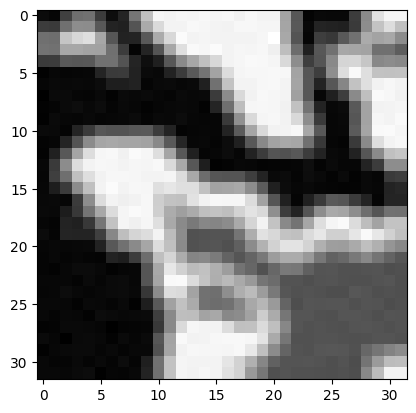

In [ ]:
# Check synthesis
for x in training_generator :
  break
plt.imshow(x[0][1, :, :, 0], cmap="gray")

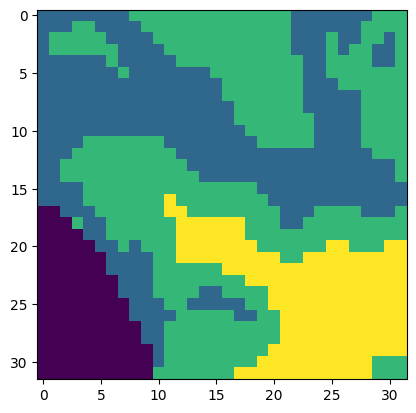

In [ ]:
plt.imshow(np.argmax(x[1][1, :, :, :], axis=-1))

**Train network**

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FOLDER, monitor='loss', save_best_only=True)
]

training_generator = DataGenerator(training_patches_seg)

unet = get_unet()
unet.compile(optimizer=OPTIMISER, loss=LOSS)
h = unet.fit(
    x=training_generator,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.9167 - val_loss: 9.1254
Epoch 2/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.7955 - val_loss: 5.9741
Epoch 3/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.7199 - val_loss: 6.5350
Epoch 4/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.6537 - val_loss: 6.0896
Epoch 5/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.6043 - val_loss: 7.2482
Epoch 6/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.5692 - val_loss: 6.5643
Epoch 7/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.5469 - val_loss: 7.1988


**Load best model**

In [ ]:
unet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)

unet.compile(optimizer=OPTIMISER, loss=LOSS)
unet.load_weights(MODEL_FOLDER)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Prepare test data**

In [ ]:
testing_volumes_T1_processed = testing_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2]])

**Predict labels for test data**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


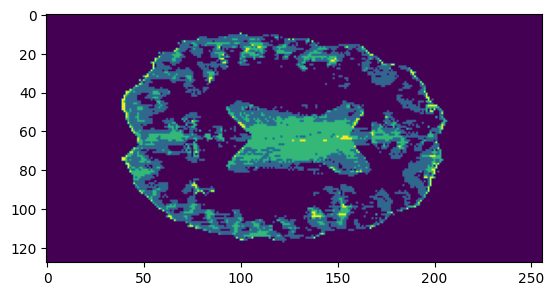

In [ ]:
prediction = unet.predict(x=testing_volumes_T1_processed)

prediction = np.argmax(prediction, axis=3)

plt.imshow(prediction[:, :, 150])

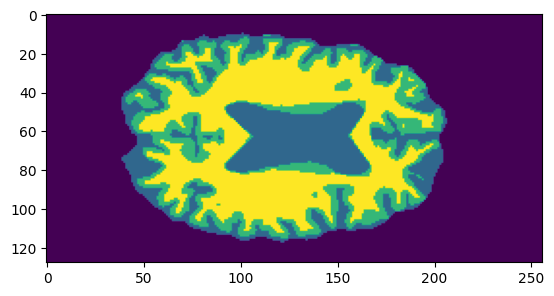

In [ ]:
plt.imshow(testing_labels[0, :, :, 150])

**Compute metrics for test data**

In [ ]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 16.9 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762838 sha256=75817230e93fadf4362cf1c573baf10aedbc885466dc44ccac27ee2be175bd4e
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [ ]:
import numpy as np
import nibabel as nib
from medpy.metric.binary import dc, hd, ravd

def compute_dice(prediction, reference) :
  for c in np.unique(reference) :
    dsc_val = dc(prediction == c, reference==c)
    print(f'Dice coefficient class {c} equal to {dsc_val : .2f}')

def compute_hd(prediction, reference, voxel_spacing) :
  for c in np.unique(prediction) :
    hd_val = hd(prediction == c, reference==c, voxelspacing=voxel_spacing, connectivity=1)
    print(f'Hausdorff distance class {c} equal to {hd_val : .2f}')

def compute_ravd(prediction, reference) :
  for c in np.unique(prediction) :
    ravd_val = ravd(prediction == c, reference==c)
    print(f'RAVD coefficient class {c} equal to {ravd_val : .2f}')

compute_dice(prediction, testing_labels_processed) # the higher -> the better
compute_hd(prediction, testing_labels_processed, [1, 1, 1]) # the lower -> the better
compute_ravd(prediction, testing_labels_processed) # the closer to zero -> the better

Dice coefficient class 0.0 equal to  1.00
Dice coefficient class 1.0 equal to  0.13
Dice coefficient class 2.0 equal to  0.46
Dice coefficient class 3.0 equal to  0.00
Hausdorff distance class 0 equal to  41.30
Hausdorff distance class 1 equal to  14.18
Hausdorff distance class 2 equal to  9.85
Hausdorff distance class 3 equal to  17.72
RAVD coefficient class 0 equal to  0.01
RAVD coefficient class 1 equal to  1.43
RAVD coefficient class 2 equal to -0.22
RAVD coefficient class 3 equal to -0.84
